# **Money Authenticity Detection for Visual Impaired with CNN**

In [3]:
# Sambungin ke google drive pribadi untuk akses dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from io import BytesIO
from ipywidgets import widgets
from tensorflow.keras.utils import load_img, img_to_array
import json
from sklearn.utils import resample

## Dataset Exploration
```
.
│── Genuine Rupiah Banknotes/
│   ├── 1000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 2000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 5000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   ├── 10000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 20000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 50000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 75000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 100000/
│       ├── image_1.jpg
│       ├── image_2.jpg
│       └── ...
└── Counterfeit Rupiah Banknotes/
    ├── 1000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 2000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 5000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    ├── 10000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 20000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 50000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 75000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 100000/
        ├── image_1.jpg
        ├── image_2.jpg
        └── ...

```

In [4]:
# Directory that holds the data

# # Kalau datasetnya dishortcut ke drive pribadi
# DATA_DIR = r'/content/drive/MyDrive/Datasets'

# Kalau dijalanin di google collab/online platform
DATA_DIR = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Multi Label Classification/Datasets'

# Kalau dijalanin di local
# DATA_DIR = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Datasets'

# Subdirectories for genuine and counterfeit banknotes
data_dir_genuine = os.path.join(DATA_DIR, 'Genuine Rupiah Banknotes')
data_dir_counterfeit = os.path.join(DATA_DIR, 'Counterfeit Rupiah Banknotes')

# Dictionary to hold subdirectories for each nominal value
nominal_values = ['1000', '2000', '5000', '10000', '20000', '50000', '75000', '100000']
data_counts = {'Nominal': [], 'Type': [], 'Count': []}

There are 224 genuine images of nominal 1000 Rupiah banknotes.
There are 33 counterfeit images of nominal 1000 Rupiah banknotes.
------------------------------------------------------------------
There are 115 genuine images of nominal 2000 Rupiah banknotes.
There are 42 counterfeit images of nominal 2000 Rupiah banknotes.
------------------------------------------------------------------
There are 267 genuine images of nominal 5000 Rupiah banknotes.
There are 38 counterfeit images of nominal 5000 Rupiah banknotes.
------------------------------------------------------------------
There are 243 genuine images of nominal 10000 Rupiah banknotes.
There are 37 counterfeit images of nominal 10000 Rupiah banknotes.
------------------------------------------------------------------
There are 254 genuine images of nominal 20000 Rupiah banknotes.
There are 37 counterfeit images of nominal 20000 Rupiah banknotes.
------------------------------------------------------------------
There are 211 ge

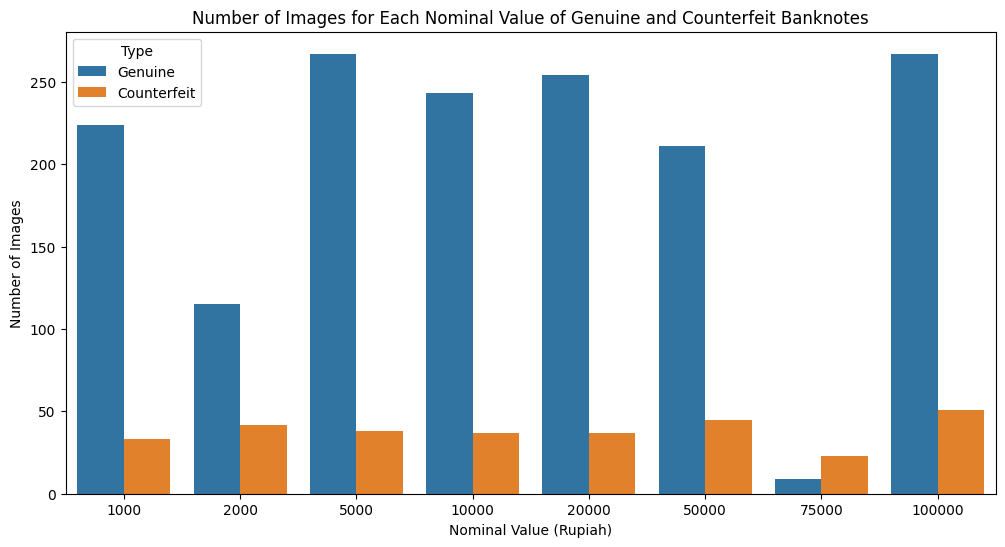

In [5]:
# Display and collect the number of images for each nominal value in both genuine and counterfeit directories
for value in nominal_values:
    genuine_path = os.path.join(data_dir_genuine, value)
    counterfeit_path = os.path.join(data_dir_counterfeit, value)

    try:
        genuine_count = len(os.listdir(genuine_path))
        print(f'There are {genuine_count} genuine images of nominal {value} Rupiah banknotes.')
        data_counts['Nominal'].append(value)
        data_counts['Type'].append('Genuine')
        data_counts['Count'].append(genuine_count)
    except FileNotFoundError:
        print(f'Directory for genuine nominal {value} not found.')

    try:
        counterfeit_count = len(os.listdir(counterfeit_path))
        print(f'There are {counterfeit_count} counterfeit images of nominal {value} Rupiah banknotes.')
        print("-" * 66)
        data_counts['Nominal'].append(value)
        data_counts['Type'].append('Counterfeit')
        data_counts['Count'].append(counterfeit_count)
    except FileNotFoundError:
        print(f'Directory for counterfeit nominal {value} not found.')

# Convert the collected data into a DataFrame for plotting
df_counts = pd.DataFrame(data_counts)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x='Nominal', y='Count', hue='Type')
plt.title('Number of Images for Each Nominal Value of Genuine and Counterfeit Banknotes')
plt.xlabel('Nominal Value (Rupiah)')
plt.ylabel('Number of Images')
plt.show()

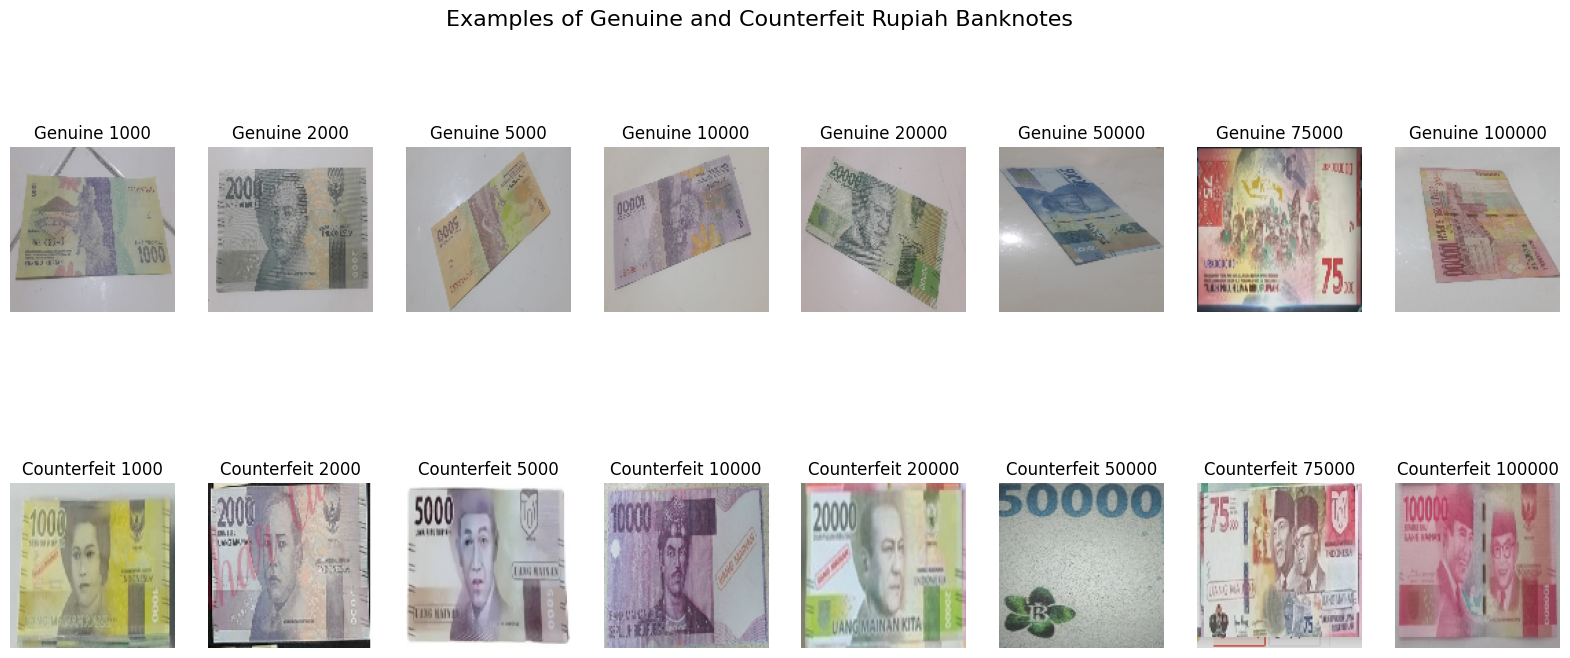

In [6]:
# Display example images for each nominal value in both genuine and counterfeit categories
fig, axes = plt.subplots(2, len(nominal_values), figsize=(20, 8))
fig.suptitle('Examples of Genuine and Counterfeit Rupiah Banknotes', fontsize=16)

# Display genuine banknotes
for i, value in enumerate(nominal_values):
    genuine_path = os.path.join(data_dir_genuine, value)
    try:
        genuine_image = os.path.join(genuine_path, os.listdir(genuine_path)[0])
        img = tf.keras.utils.load_img(genuine_image, target_size=(120, 120))  # Resize if needed
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Genuine {value}')
        axes[0, i].axis('off')
    except (FileNotFoundError, IndexError):
        axes[0, i].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[0, i].set_title(f'Genuine {value}')
        axes[0, i].axis('off')

# Display counterfeit banknotes
for i, value in enumerate(nominal_values):
    counterfeit_path = os.path.join(data_dir_counterfeit, value)
    try:
        counterfeit_image = os.path.join(counterfeit_path, os.listdir(counterfeit_path)[0])
        img = tf.keras.utils.load_img(counterfeit_image, target_size=(120, 120))  # Resize if needed
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Counterfeit {value}')
        axes[1, i].axis('off')
    except (FileNotFoundError, IndexError):
        axes[1, i].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[1, i].set_title(f'Counterfeit {value}')
        axes[1, i].axis('off')

plt.show()

## Dataset Preprocessing

### Equalize the number of datasets

In [7]:
def equalize_datasets(images, labels_authenticity, labels_nominal):
    # Separate images by authenticity
    genuine_images = images[labels_authenticity == 1]
    counterfeit_images = images[labels_authenticity == 0]
    genuine_nominal_labels = labels_nominal[labels_authenticity == 1]
    counterfeit_nominal_labels = labels_nominal[labels_authenticity == 0]

    # Balance datasets by oversampling or undersampling
    if len(genuine_images) > len(counterfeit_images):
        # Oversample counterfeit
        counterfeit_images, counterfeit_nominal_labels = resample(
            counterfeit_images,
            counterfeit_nominal_labels,
            replace=True,
            n_samples=len(genuine_images),
            random_state=42
        )
    elif len(counterfeit_images) > len(genuine_images):
        # Oversample genuine
        genuine_images, genuine_nominal_labels = resample(
            genuine_images,
            genuine_nominal_labels,
            replace=True,
            n_samples=len(counterfeit_images),
            random_state=42
        )

    # Combine the datasets
    balanced_images = np.concatenate([genuine_images, counterfeit_images], axis=0)
    balanced_authenticity_labels = np.concatenate([np.ones(len(genuine_images)), np.zeros(len(counterfeit_images))], axis=0)
    balanced_nominal_labels = np.concatenate([genuine_nominal_labels, counterfeit_nominal_labels], axis=0)

    return balanced_images, balanced_authenticity_labels, balanced_nominal_labels


In [8]:
# Integrate dataset equalization in the preprocessing function
def prepare_datasets_balanced():
    label_map = {nominal: idx for idx, nominal in enumerate(nominal_values)}

    def preprocess_image(file_path, label):
        img = tf.keras.utils.load_img(file_path, target_size=(120, 120))
        img = tf.keras.utils.img_to_array(img)
        img = img / 255.0
        return img, label

    images = []
    authenticity_labels = []
    nominal_labels = []

    for nominal in nominal_values:
        # Genuine notes
        genuine_path = os.path.join(data_dir_genuine, nominal)
        if os.path.exists(genuine_path):
            for file in os.listdir(genuine_path):
                file_path = os.path.join(genuine_path, file)
                img, _ = preprocess_image(file_path, None)
                images.append(img)
                authenticity_labels.append(1)  # Genuine
                nominal_labels.append(label_map[nominal])

        # Counterfeit notes
        counterfeit_path = os.path.join(data_dir_counterfeit, nominal)
        if os.path.exists(counterfeit_path):
            for file in os.listdir(counterfeit_path):
                file_path = os.path.join(counterfeit_path, file)
                img, _ = preprocess_image(file_path, None)
                images.append(img)
                authenticity_labels.append(0)  # Counterfeit
                nominal_labels.append(label_map[nominal])

    # Convert to NumPy arrays
    images = np.array(images)
    authenticity_labels = np.array(authenticity_labels)
    nominal_labels = np.array(nominal_labels)

    # Equalize datasets
    images, authenticity_labels, nominal_labels = equalize_datasets(images, authenticity_labels, nominal_labels)

    # Split into training, validation, and test datasets
    X_temp, X_test, y_auth_temp, y_auth_test, y_nom_temp, y_nom_test = train_test_split(
        images, authenticity_labels, nominal_labels, test_size=0.2, random_state=42
    )
    X_train, X_val, y_auth_train, y_auth_val, y_nom_train, y_nom_val = train_test_split(
        X_temp, y_auth_temp, y_nom_temp, test_size=0.1875, random_state=42
    )

    return (X_train, [y_auth_train, y_nom_train]), (X_val, [y_auth_val, y_nom_val]), (X_test, [y_auth_test, y_nom_test])

In [9]:
# Prepare balanced datasets
train_data_balanced, val_data_balanced, test_data_balanced = prepare_datasets_balanced()

There are 141 genuine images of nominal 1000 Rupiah banknotes in the balanced dataset.
There are 112 counterfeit images of nominal 1000 Rupiah banknotes in the balanced dataset.
--------------------------------------------------------------------------------------------
There are 69 genuine images of nominal 2000 Rupiah banknotes in the balanced dataset.
There are 148 counterfeit images of nominal 2000 Rupiah banknotes in the balanced dataset.
--------------------------------------------------------------------------------------------
There are 161 genuine images of nominal 5000 Rupiah banknotes in the balanced dataset.
There are 116 counterfeit images of nominal 5000 Rupiah banknotes in the balanced dataset.
--------------------------------------------------------------------------------------------
There are 165 genuine images of nominal 10000 Rupiah banknotes in the balanced dataset.
There are 131 counterfeit images of nominal 10000 Rupiah banknotes in the balanced dataset.
--------

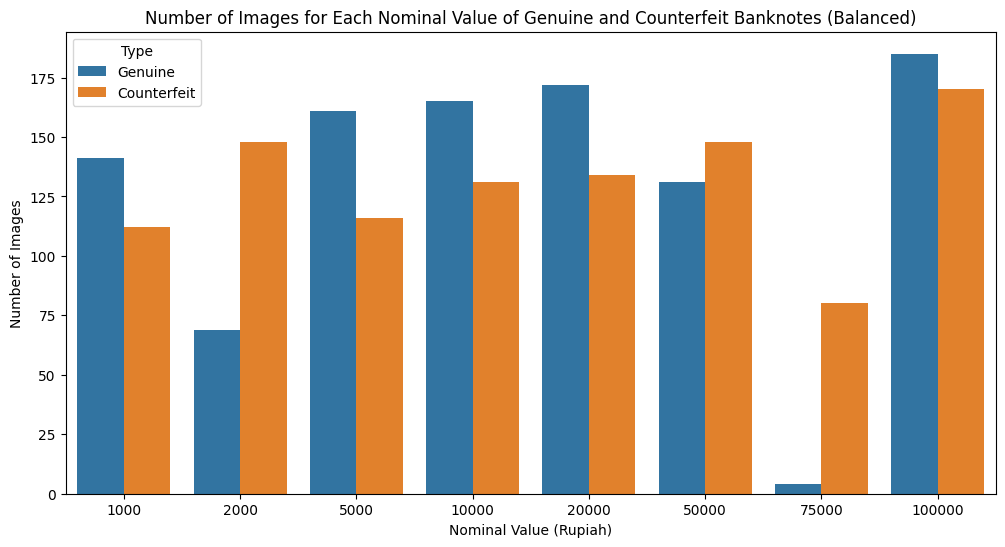

In [10]:
# Display and collect the number of images for each nominal value in both genuine and counterfeit datasets after balancing
data_counts_balanced = {'Nominal': [], 'Type': [], 'Count': []}

# Count the images for genuine and counterfeit datasets
def collect_balanced_counts(images, authenticity_labels, nominal_labels):
    for nominal, nominal_idx in zip(nominal_values, range(len(nominal_values))):
        # Count genuine and counterfeit for the current nominal value
        genuine_count = np.sum((nominal_labels == nominal_idx) & (authenticity_labels == 1))
        counterfeit_count = np.sum((nominal_labels == nominal_idx) & (authenticity_labels == 0))

        # Append results for plotting
        data_counts_balanced['Nominal'].extend([nominal, nominal])
        data_counts_balanced['Type'].extend(['Genuine', 'Counterfeit'])
        data_counts_balanced['Count'].extend([genuine_count, counterfeit_count])

# Unpack balanced training, validation, and test datasets
X_train, [y_auth_train, y_nom_train] = train_data_balanced
X_val, [y_auth_val, y_nom_val] = val_data_balanced
X_test, [y_auth_test, y_nom_test] = test_data_balanced

# Display and collect the exact number of images for each nominal value in both genuine and counterfeit datasets (balanced)
for value, nominal_idx in zip(nominal_values, range(len(nominal_values))):
    # Count genuine images for the current nominal value
    genuine_count = np.sum((y_nom_train == nominal_idx) & (y_auth_train == 1))
    print(f"There are {genuine_count} genuine images of nominal {value} Rupiah banknotes in the balanced dataset.")

    # Count counterfeit images for the current nominal value
    counterfeit_count = np.sum((y_nom_train == nominal_idx) & (y_auth_train == 0))
    print(f"There are {counterfeit_count} counterfeit images of nominal {value} Rupiah banknotes in the balanced dataset.")

    print("-" * 92)


# Collect counts from balanced datasets
collect_balanced_counts(X_train, y_auth_train, y_nom_train)

# Convert the collected data into a DataFrame for plotting
df_counts_balanced = pd.DataFrame(data_counts_balanced)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts_balanced, x='Nominal', y='Count', hue='Type')
plt.title('Number of Images for Each Nominal Value of Genuine and Counterfeit Banknotes (Balanced)')
plt.xlabel('Nominal Value (Rupiah)')
plt.ylabel('Number of Images')
plt.show()

In [11]:
def count_datasets(images, authenticity_labels, nominal_labels):
    # Count genuine and counterfeit images
    num_genuine = np.sum(authenticity_labels == 1)
    num_counterfeit = np.sum(authenticity_labels == 0)

    # Count images for each nominal value
    nominal_counts = {nominal: 0 for nominal in nominal_values}
    for nominal, label in zip(nominal_values, range(len(nominal_values))):
        nominal_counts[nominal] = np.sum(nominal_labels == label)

    return num_genuine, num_counterfeit, nominal_counts

# Count datasets
train_genuine, train_counterfeit, train_nominal_counts = count_datasets(X_train, y_auth_train, y_nom_train)
val_genuine, val_counterfeit, val_nominal_counts = count_datasets(X_val, y_auth_val, y_nom_val)
test_genuine, test_counterfeit, test_nominal_counts = count_datasets(X_test, y_auth_test, y_nom_test)

# Print dataset counts
print("Training Dataset Counts:")
print(f"  Genuine: {train_genuine}, Counterfeit: {train_counterfeit}")
print(f"  Nominal Counts: {train_nominal_counts}")
print()
print("Validation Dataset Counts:")
print(f"  Genuine: {val_genuine}, Counterfeit: {val_counterfeit}")
print(f"  Nominal Counts: {val_nominal_counts}")
print()
print("Test Dataset Counts:")
print(f"  Genuine: {test_genuine}, Counterfeit: {test_counterfeit}")
print(f"  Nominal Counts: {test_nominal_counts}")


Training Dataset Counts:
  Genuine: 1028, Counterfeit: 1039
  Nominal Counts: {'1000': 253, '2000': 217, '5000': 277, '10000': 296, '20000': 306, '50000': 279, '75000': 84, '100000': 355}

Validation Dataset Counts:
  Genuine: 229, Counterfeit: 248
  Nominal Counts: {'1000': 48, '2000': 56, '5000': 77, '10000': 61, '20000': 70, '50000': 78, '75000': 18, '100000': 69}

Test Dataset Counts:
  Genuine: 333, Counterfeit: 303
  Nominal Counts: {'1000': 96, '2000': 61, '5000': 106, '10000': 75, '20000': 79, '50000': 90, '75000': 24, '100000': 105}


## Create Augmentation Model

In [55]:
def create_augmentation_model_nom():
    FILL_MODE_NOM = 'nearest'

    augmentation_model = tf.keras.Sequential([
		    tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE_NOM),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE_NOM),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2)
    ])

    return augmentation_model

## Create Model

In [56]:
def create_multi_output_model():
    # Initialize the augmentation model
    augmentation_model = create_augmentation_model_nom()

    # Define the input layer
    inputs = tf.keras.Input(shape=(120, 120, 3))

    # Apply augmentation
    x = augmentation_model(inputs)

    # Common feature extractor
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output for authenticity classification
    authenticity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='authenticity', kernel_regularizer=l2(0.001))(x)

    # Increased capacity for nominal classification
    nominal_dense = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    nominal_dense = tf.keras.layers.Dropout(0.5)(nominal_dense)

    # Output for nominal classification
    nominal_output = tf.keras.layers.Dense(len(nominal_values), activation='softmax', name='nominal', kernel_regularizer=l2(0.001))(nominal_dense)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=[authenticity_output, nominal_output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'authenticity': 'binary_crossentropy',
            'nominal': 'sparse_categorical_crossentropy',
        },
        metrics={
            'authenticity': 'accuracy',
            'nominal': 'accuracy',
        }
    )

    return model

In [57]:
# Create and compile the model
multi_output_model = create_multi_output_model()

In [58]:
multi_output_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 120, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 118, 118, 32)   │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 59, 59, 32)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 28, 28, 64)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 26, 26, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 13, 13, 128)    │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 11, 11, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 5, 5, 256)      │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 6400)           │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 6400)           │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │      3,277,312 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ authenticity (Dense)      │ (None, 1)              │          6,401 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nominal (Dense)           │ (None, 8)              │          4,104 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,676,233 (14.02 MB)

 Trainable params: 3,676,233 (14.02 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Model evaluation for compatibility
try:
    multi_output_model.evaluate(val_data_balanced[0], val_data_balanced[1], verbose=False)
except ValueError as e:
    print(f'Model evaluation error: {e}')
    print('The model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.')
else:
    print('The model work well with the datasets.')

The model work well with the datasets.


In [60]:
# Train the model
history = multi_output_model.fit(
    train_data_balanced[0], train_data_balanced[1],
    epochs=20,
    batch_size=32,
    validation_data=(val_data_balanced[0], val_data_balanced[1])
)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - authenticity_accuracy: 0.5581 - authenticity_loss: 0.6856 - loss: 3.4729 - nominal_accuracy: 0.1980 - nominal_loss: 2.0039 - val_authenticity_accuracy: 0.6164 - val_authenticity_loss: 0.6537 - val_loss: 2.7185 - val_nominal_accuracy: 0.3082 - val_nominal_loss: 1.7586
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - authenticity_accuracy: 0.6593 - authenticity_loss: 0.5986 - loss: 2.3689 - nominal_accuracy: 0.4401 - nominal_loss: 1.4918 - val_authenticity_accuracy: 0.7086 - val_authenticity_loss: 0.5351 - val_loss: 1.9075 - val_nominal_accuracy: 0.5702 - val_nominal_loss: 1.1322
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - authenticity_accuracy: 0.7205 - authenticity_loss: 0.5202 - loss: 1.9031 - nominal_accuracy: 0.5915 - nominal_loss: 1.1437 - val_authenticity_accuracy: 0.7631 - val_authenticity_loss: 0.4609 - val_loss: 1.7241 - val_nominal_accuracy: 0.6268 - val_nominal_loss: 1.0116
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8

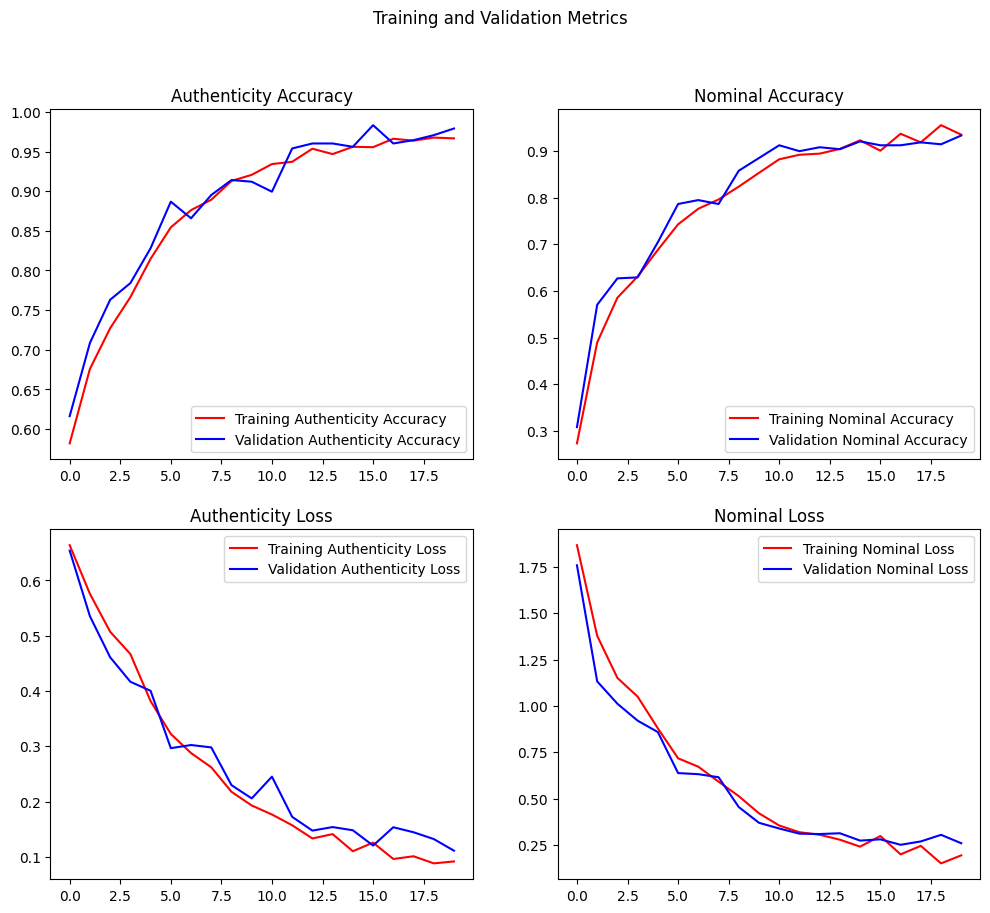

In [61]:
auth_acc = history.history['authenticity_accuracy']
auth_val_acc = history.history['val_authenticity_accuracy']
nom_acc = history.history['nominal_accuracy']
nom_val_acc = history.history['val_nominal_accuracy']

auth_loss = history.history['authenticity_loss']
auth_val_loss = history.history['val_authenticity_loss']
nom_loss = history.history['nominal_loss']
nom_val_loss = history.history['val_nominal_loss']

epochs = range(len(auth_acc))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Training and Validation Metrics')

# Plot authenticity accuracy
axs[0, 0].plot(epochs, auth_acc, 'r', label='Training Authenticity Accuracy')
axs[0, 0].plot(epochs, auth_val_acc, 'b', label='Validation Authenticity Accuracy')
axs[0, 0].set_title('Authenticity Accuracy')
axs[0, 0].legend()

# Plot nominal accuracy
axs[0, 1].plot(epochs, nom_acc, 'r', label='Training Nominal Accuracy')
axs[0, 1].plot(epochs, nom_val_acc, 'b', label='Validation Nominal Accuracy')
axs[0, 1].set_title('Nominal Accuracy')
axs[0, 1].legend()

# Plot authenticity loss
axs[1, 0].plot(epochs, auth_loss, 'r', label='Training Authenticity Loss')
axs[1, 0].plot(epochs, auth_val_loss, 'b', label='Validation Authenticity Loss')
axs[1, 0].set_title('Authenticity Loss')
axs[1, 0].legend()

# Plot nominal loss
axs[1, 1].plot(epochs, nom_loss, 'r', label='Training Nominal Loss')
axs[1, 1].plot(epochs, nom_val_loss, 'b', label='Validation Nominal Loss')
axs[1, 1].set_title('Nominal Loss')
axs[1, 1].legend()

plt.show()

## Testing Model

In [62]:
results = multi_output_model.evaluate(
    x=test_data_balanced[0],
    y={'authenticity': test_data_balanced[1][0], 'nominal': test_data_balanced[1][1]},
    verbose=1
)

# Print evaluation results
print(f'Total Test Loss: {results[0]}')
print(f'Authenticity Test Loss: {results[1]}')
print(f'Nominal Test Loss: {results[2]}')
print(f'Authenticity Test Accuracy: {results[3]}')
print(f'Nominal Test Accuracy: {results[4]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - authenticity_accuracy: 0.9689 - authenticity_loss: 0.0770 - loss: 0.8043 - nominal_accuracy: 0.9443 - nominal_loss: 0.2152
Total Test Loss: 0.8152899742126465
Authenticity Test Loss: 0.08624963462352753
Nominal Test Loss: 0.21829891204833984
Authenticity Test Accuracy: 0.9669811129570007
Nominal Test Accuracy: 0.9433962106704712


## Model Application

### Test with single file from directory

In [72]:
# Function to predict authenticity and nominal
def predict_image(file_path):
    # Load and preprocess the image to match model's input size (120, 120)
    image = load_img(file_path, target_size=(120, 120))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Multi-output prediction
    authenticity_pred, nominal_pred = multi_output_model.predict(image, verbose=0)

    # Convert authenticity prediction to human-readable format
    authenticity = 'Genuine' if authenticity_pred[0] > 0.5 else 'Counterfeit'

    # Get nominal class prediction and map it to nominal value
    nominal = nominal_values[np.argmax(nominal_pred)]  # Map to nominal value

    return authenticity, nominal

# Path to the image file you want to predict

# # Kalau pathnya dishortcut ke drive pribadi Ulhaq
# file_path = r'/content/drive/MyDrive/Data Example (buat eksperimen)/Uang Fake/Uang Fake 5000.jpg'

# Kalau pathnya dishortcut ke drive pribadi Kresna
file_path = r'/content/drive/MyDrive/bangkit capstone/WhatsApp Image 2024-12-04 at 22.03.01_706b6186.jpg'

# # Kalau dijalanin di google collab/online platform
# file_path = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Data Example (buat eksperimen)/Uang Fake/Uang Fake 20000.jpg'

# Kalau dijalanin di local
# file_path = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Data Example\Uang Fake\Uang Fake 5000.jpg'


# Call the function with the file path
authenticity, nominal = predict_image(file_path)

# Print the result
print(f'File: {file_path}')
print(f'Authenticity: {authenticity}')
print(f'Nominal: Rp{nominal}')

File: /content/drive/MyDrive/bangkit capstone/WhatsApp Image 2024-12-04 at 22.03.01_706b6186.jpg
Authenticity: Genuine
Nominal: Rp100000


### Test with all file in directory

In [69]:
# Directory path containing test images

# # Kalau pathnya dishortcut ke drive pribadi
# test_dir = r'/content/drive/MyDrive/Data Example (buat eksperimen)/Uang Fake'

# Kalau dijalanin di google collab/online platform
test_dir = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Data Example (buat eksperimen)/Uang Fake'

# # Kalau dijalanin di local
# test_dir = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Data Example\Uang Fake'

# Function to predict authenticity and nominal
def predict_image_from_path(file_path):
    # Load and preprocess the image to match model's input size (120, 120)
    image = load_img(file_path, target_size=(120, 120))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Multi-output prediction
    authenticity_pred, nominal_pred = multi_output_model.predict(image, verbose=0)

    # Convert authenticity prediction to human-readable format
    authenticity = 'Genuine' if authenticity_pred[0] > 0.5 else 'Counterfeit'

    # Get nominal class prediction and map it to nominal value
    nominal = nominal_values[np.argmax(nominal_pred)]  # Map to nominal value

    return authenticity, nominal

# Loop through images in directory
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Validate file type
        authenticity, nominal = predict_image_from_path(file_path)
        print(f"{file_name}: {authenticity}, Nominal: Rp{nominal}")


Uang Fake 1000.png: Counterfeit, Nominal: Rp1000
Uang Fake 100000.jpg: Counterfeit, Nominal: Rp100000
Uang Fake 75000.jpg: Counterfeit, Nominal: Rp75000
Uang Fake 20000.jpg: Counterfeit, Nominal: Rp20000
Uang Fake 10000.jpg: Counterfeit, Nominal: Rp10000
Uang Fake 5000.jpg: Counterfeit, Nominal: Rp5000
Uang Fake 2000.jpg: Counterfeit, Nominal: Rp2000
Uang Fake 50000.jpg: Counterfeit, Nominal: Rp50000


### Test with choosing file

In [37]:
# File uploader widget
uploader = widgets.FileUpload(accept='image/*', multiple=True)
display(uploader)

# Output widget
out = widgets.Output()
display(out)

# Function to predict file authenticity and nominal
def file_predict(filename, file, out):
    # Resize the image to fit the model input
    image = tf.keras.utils.load_img(file, target_size=(120, 120))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Predict using model
    prediction = multi_output_model.predict(image, verbose=0)

    # Take the result for both authenticity and nominal
    authenticity_prediction = prediction[0][0]
    nominal_prediction = prediction[1]

    with out:
        # Result for authenticity
        if authenticity_prediction > 0.5:
            print(f'{filename} is a genuine rupiah banknote')
        else:
            print(f'{filename} is a counterfeit rupiah banknote')

        # Result for nominal
        predicted_nominal = np.argmax(nominal_prediction)
        print(f'Predicted nominal: {nominal_values[predicted_nominal]}')

# Function to handle file uploads
def on_upload_change(change):
    # Clear output before displaying new results
    out.clear_output()

    # Iterate over uploaded files
    for file_info in uploader.value:
        # Extract file name and content
        filename = file_info['name']
        file_content = file_info['content']

        # Convert file content to BytesIO for model prediction
        file_bytes = BytesIO(file_content)
        file_predict(filename, file_bytes, out)

# Observe uploader for changes
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

TypeError: string indices must be integers

## Convert Model

### Convert to Keras

In [ ]:
# Save the trained model as a Keras file
# Path Online
saved_model_path_keras = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Multi Label Classification/Convert Model Result_V2_Augment/Money-Authenticity-Detection_Model.keras'
# # Path Local
# saved_model_path_keras = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Convert Model Result\Money-Authenticity-Detection_Model.keras'

multi_output_model.save(saved_model_path_keras)

print(f'Model with H5 format successfully saved in {saved_model_path_keras}')

Model with H5 format successfully saved in /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.keras


### Convert to H5

In [ ]:
# Save the trained model as a Keras HDF5 file
# Path Online
saved_model_path_h5 = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Multi Label Classification/Convert Model Result_V2_Augment/Money-Authenticity-Detection_Model.h5'
# # Path Local
# saved_model_path_h5 = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Convert Model Result\Money-Authenticity-Detection_Model.h5'

multi_output_model.save(saved_model_path_h5)

print(f'Model with H5 format successfully saved in {saved_model_path_h5}')

Model with H5 format successfully saved in /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.h5


### Convert to JSON

In [ ]:
# Get the model configuration in JSON format
model_json = multi_output_model.to_json()

# Save the model configuration to a .json file
# Path Online
json_file_path = '/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna-Deteksi Uang dengan CNN/Multi Label Classification/Convert Model Result_V2_Augment/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.json'
# # Path Local
# json_file_path = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Convert Model Result\Money-Authenticity-Detection_Model.json'
# with open(json_file_path, 'w') as json_file:
#     json.dump(model_json, json_file)

print(f'Model successfully converted to JSON and saved at {json_file_path}')

Model successfully converted to JSON and saved at /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.json
